# Text Analysis

In [1]:
%load_ext autoreload
%autoreload 2

In [3]:
from utils.analysis_helpers import *
from utils.clusters_helpers import *

## Choose features of the data to analyse
- Drop or select specifics conditions
- Differentiate between interviwer & participant

In [4]:
directory = '../interviews_corrected/5_conditions/**/' 

df = load_and_combine_csv(directory)
df = standardize_data(df)
df = calculate_word_char_counts(df)

df.to_csv("outputs/combined_data.csv", index=False)

Found 82 CSV files.
Standardized speaker labels.
Normalized text in 'Content' column.
Calculated 'Word_Count' and 'Character_Count' for each response.


In [5]:
print(df["Condition"].unique())
# Drop the rows equal to 0 for the column condition
df = df[df["Condition"] != 0]
print(df["Condition"].unique())

[1 'C' 'I' 0]
[1 'C' 'I']


In [6]:
# If only want to focus on participant speaker
df_participant = df[df["Speaker"] == "Participant"]
df_interviewer = df[df["Speaker"] == "Interviewer"]

### Word Count

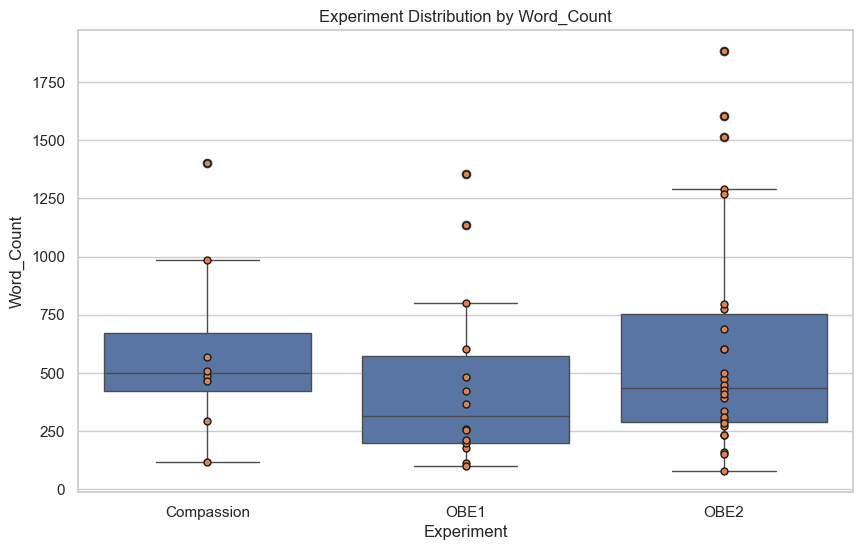

In [7]:
stripplot(aggregate_counts(df_participant,["Experiment","Id"]), 'Experiment', 'Word_Count')

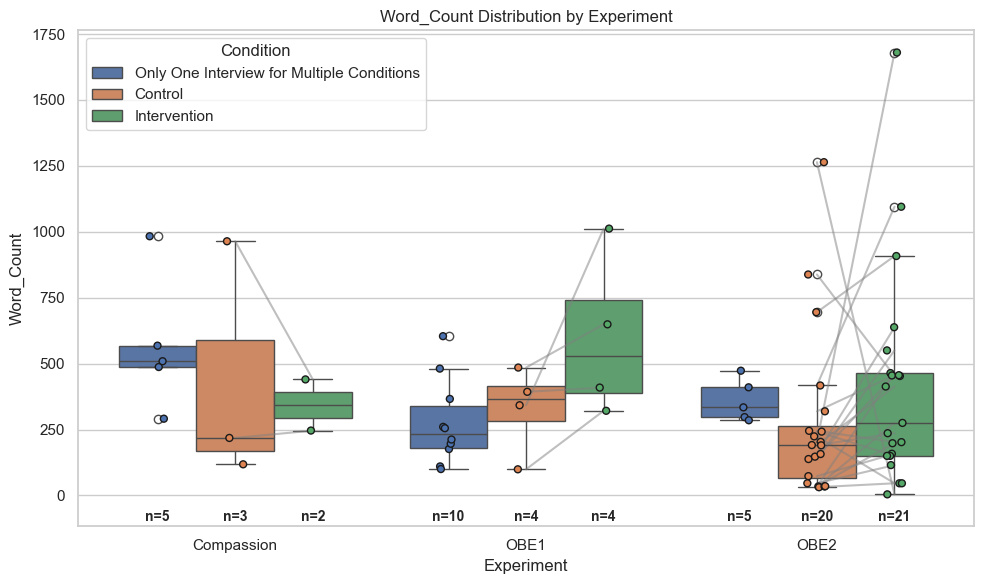

In [8]:
# Group by Id instead of File Name because the same participant can have the same condition in different interviews
stripplot_with_counts(aggregate_counts(df_participant, ['Experiment', "Id", "Condition"]), 'Experiment', 'Word_Count', 
                      hue_column='Condition', id_column="Id", legend_labels=["Only One Interview for Multiple Conditions","Control","Intervention"])#,file_name="stripplot_word_count_id.png")

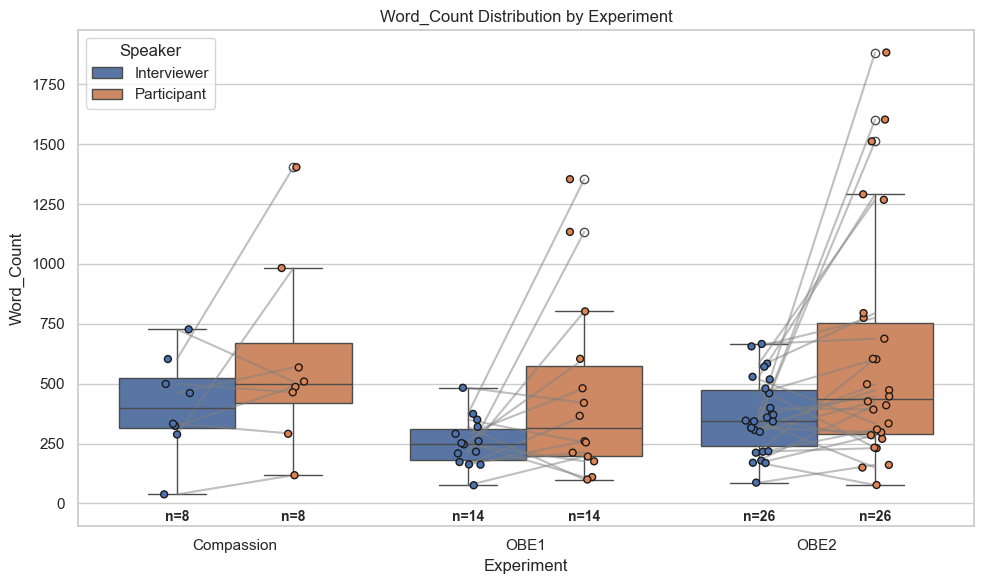

In [9]:
stripplot_with_counts(aggregate_counts(df, ['Experiment', "Id", 'Speaker']), 'Experiment', 'Word_Count', hue_column='Speaker', id_column="Id")

### Frequency & Unique Words

In [10]:
extra_words_to_exclude = ["yeah", "like", "okay" ,"really", "it", "yes","could","kind","bit","think","that's"] 

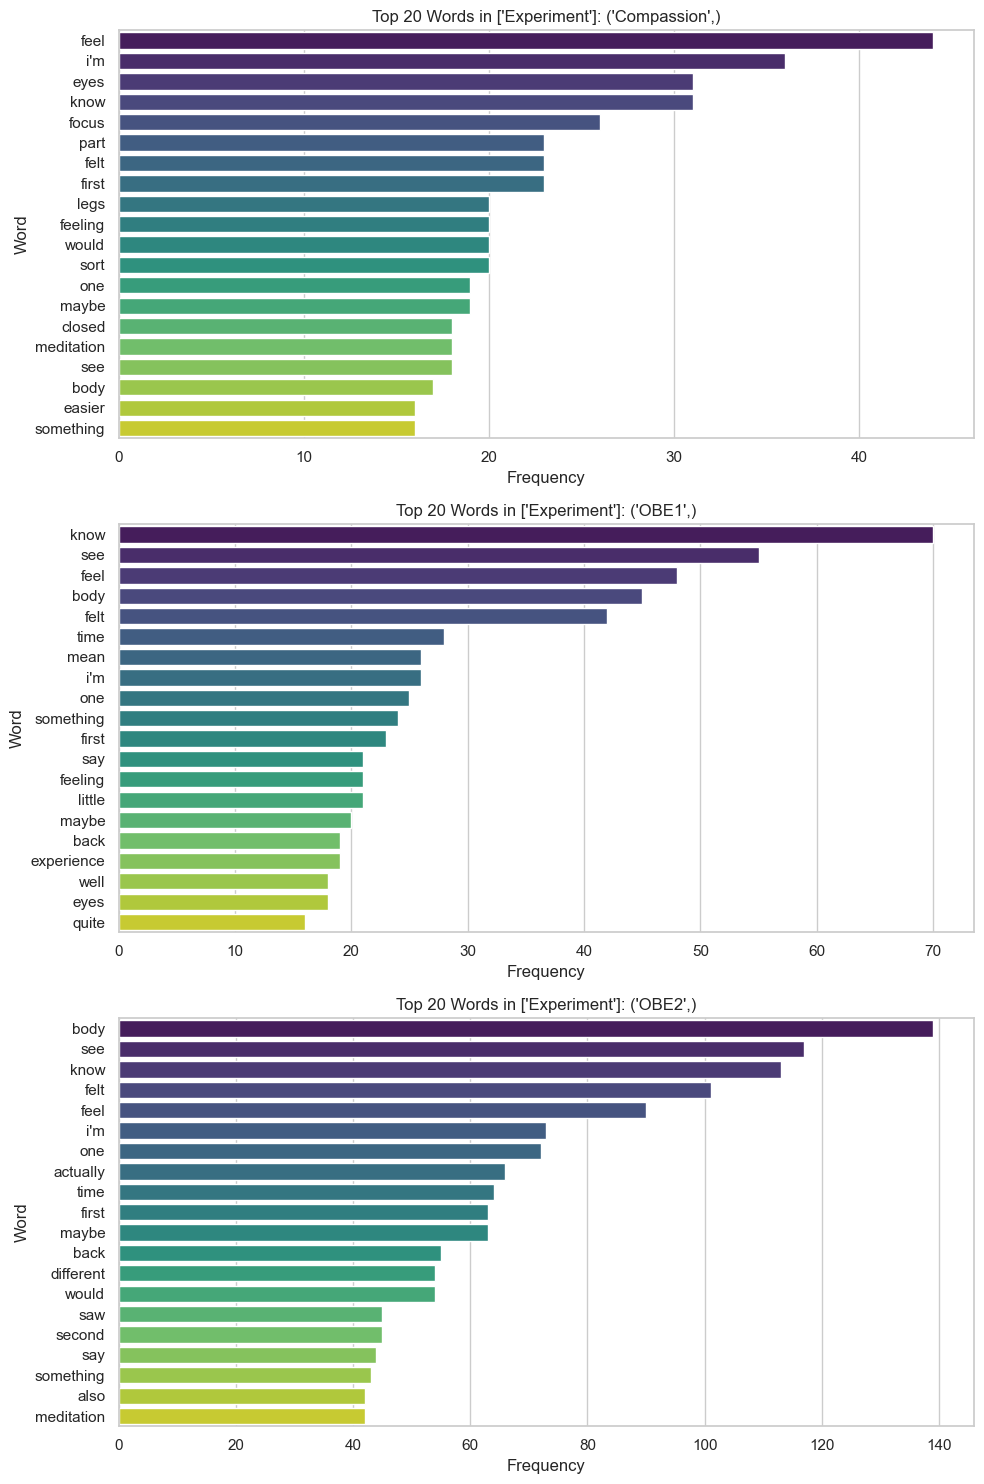

In [11]:
word_frequency_plot(df_participant, groupby_column=["Experiment"], extra_stopwords=extra_words_to_exclude)

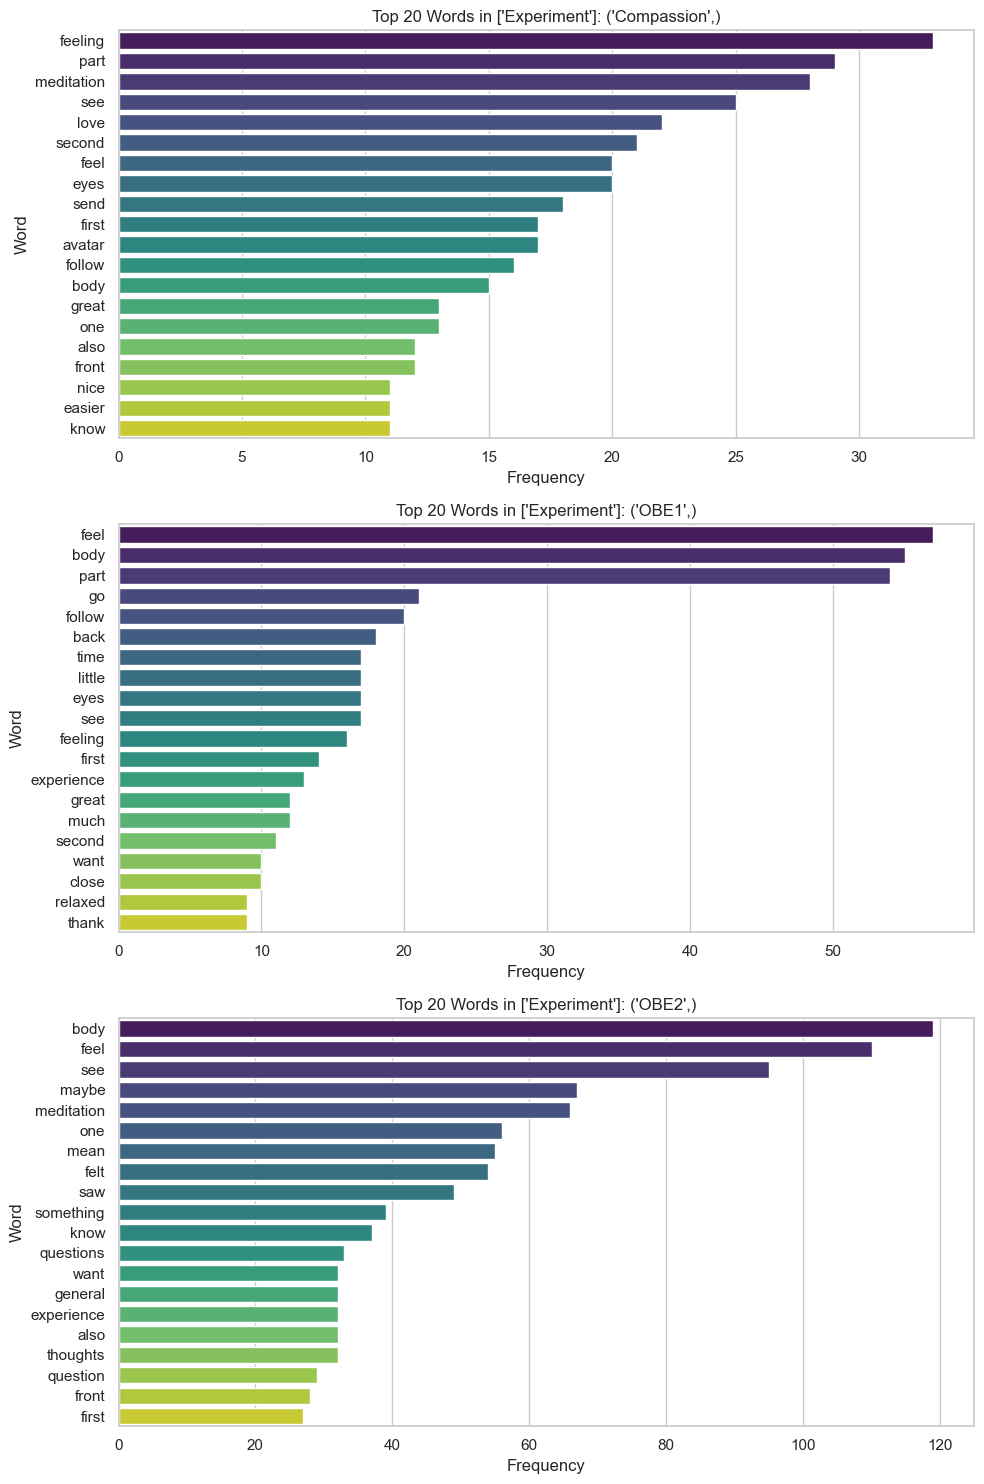

In [12]:
word_frequency_plot(df_interviewer, groupby_column=["Experiment"], extra_stopwords=extra_words_to_exclude)

In [13]:
# You can specify any list of columns for grouping, e.g., ['Experiment', 'Condition']
unique_words_df_participant = count_unique_words(df_participant, groupby_columns=['Experiment', 'Condition'], omit_stop_words=True, extra_stopwords=extra_words_to_exclude)
unique_words_df_participant = unique_words_df_participant.sort_values(by='Participant_Count', ascending=False)
unique_words_df_participant.to_csv("outputs/unique_words_participant.csv", index=False)

unique_words_df_interviewer = count_unique_words(df_interviewer, groupby_columns=['Experiment', 'Condition'], omit_stop_words=True, extra_stopwords=extra_words_to_exclude)
unique_words_df_interviewer = unique_words_df_interviewer.sort_values(by='Participant_Count', ascending=False)
unique_words_df_interviewer.to_csv("outputs/unique_words_interviewer.csv", index=False)

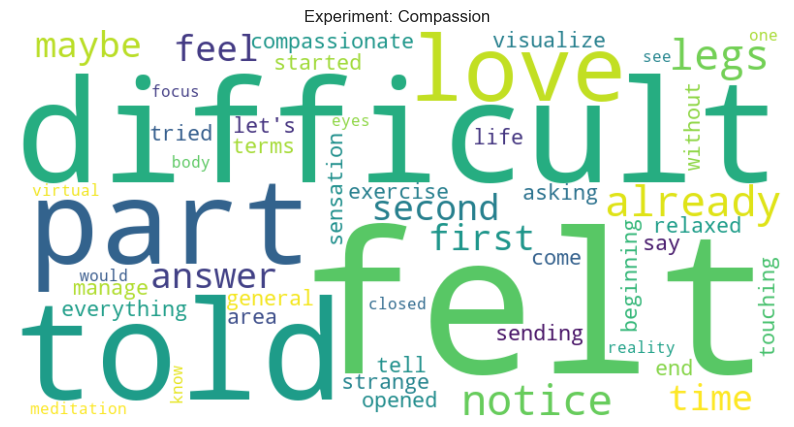

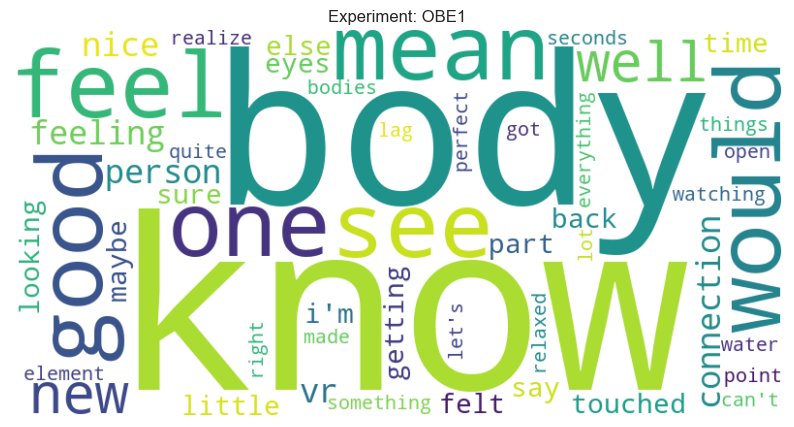

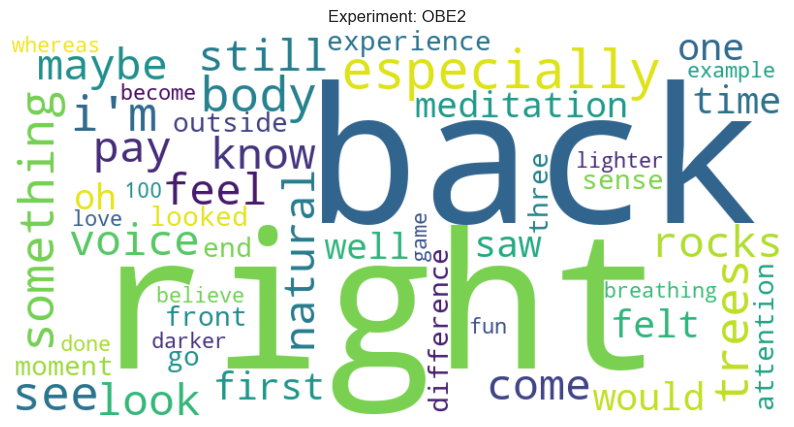

In [14]:
generate_word_clouds(unique_words_df_participant, groupby_columns=['Experiment'])

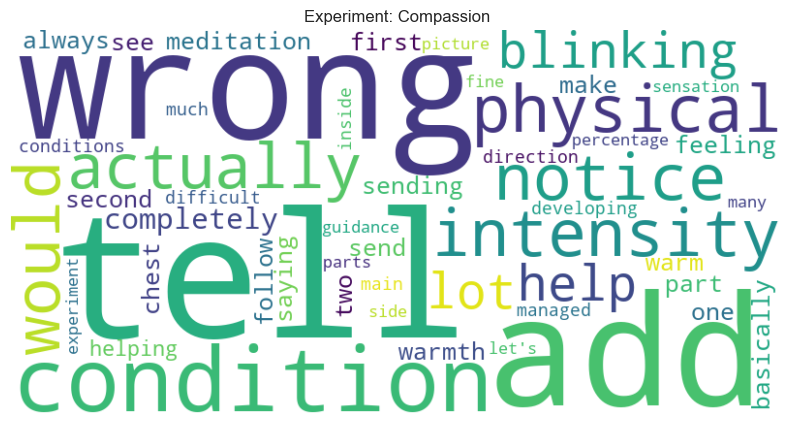

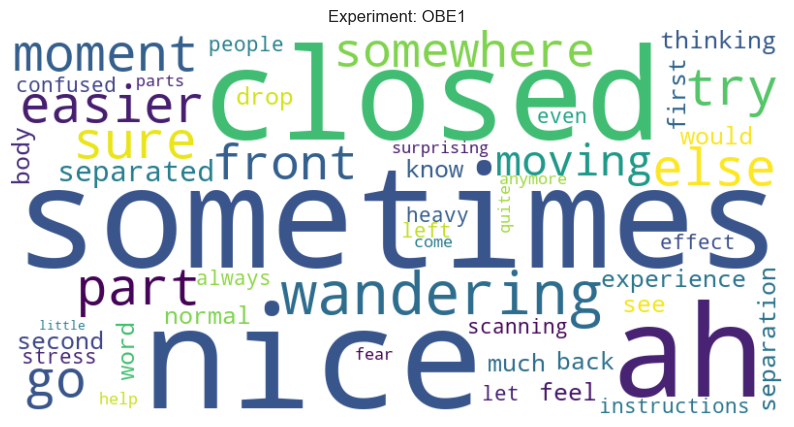

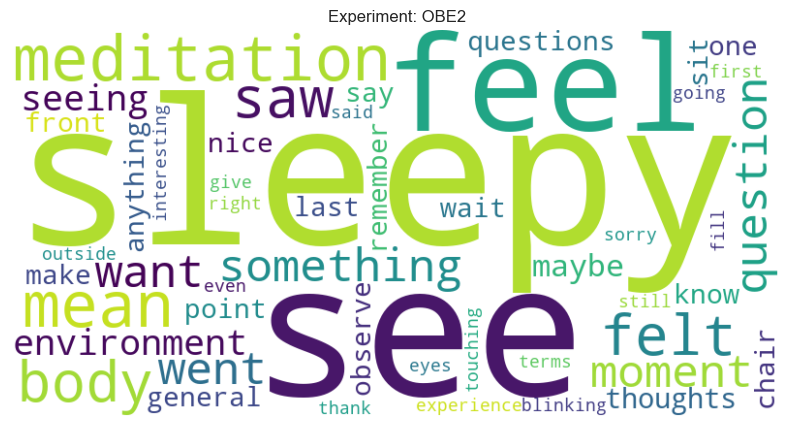

In [15]:
generate_word_clouds(unique_words_df_interviewer, groupby_columns=['Experiment'])

### Cluster 1.0

In [16]:
# Preprocess text
df_participant.loc[:, 'preprocessed_content'] = df_participant['Content'].apply(preprocess_text)

# Group data by Experiment and Participant
grouped_df = df_participant.groupby(['Experiment', 'Id'])['preprocessed_content'].apply(' '.join).reset_index()

# Perform clustering with both methods
clustered_dfs_tfidf, tfidf_matrices = cluster_tfidf_kmeans(grouped_df, 2)
clustered_dfs_bert, bert_matrices = cluster_bert_kmeans(grouped_df, 2)

C:\Users\david\AppData\Local\Temp\ipykernel_21228\2470399989.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_participant.loc[:, 'preprocessed_content'] = df_participant['Content'].apply(preprocess_text)


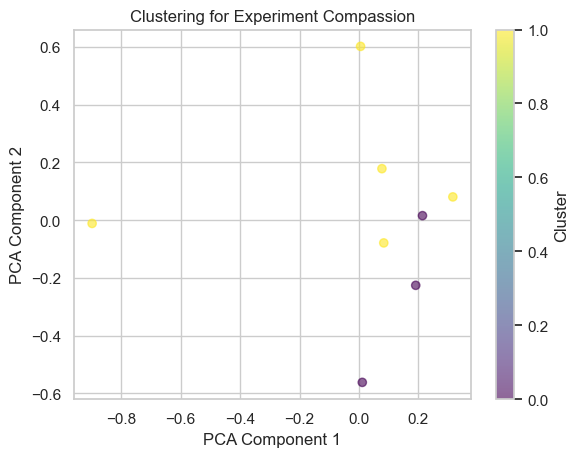

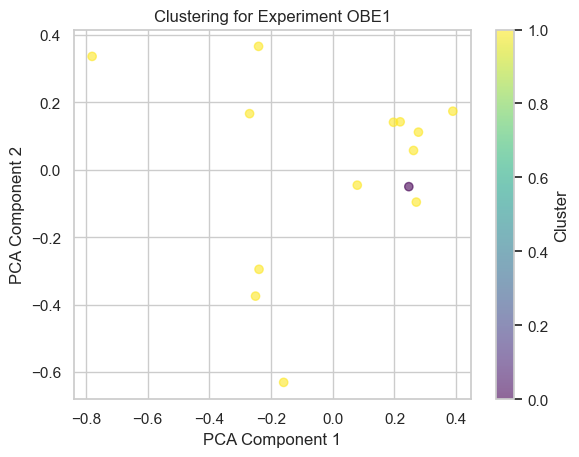

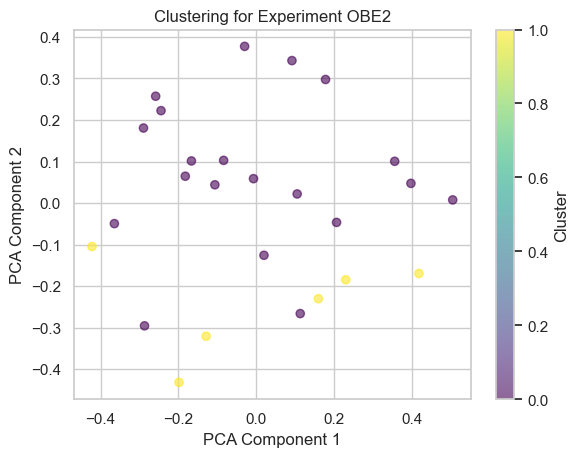

In [17]:
visualize_clusters(clustered_dfs_tfidf)

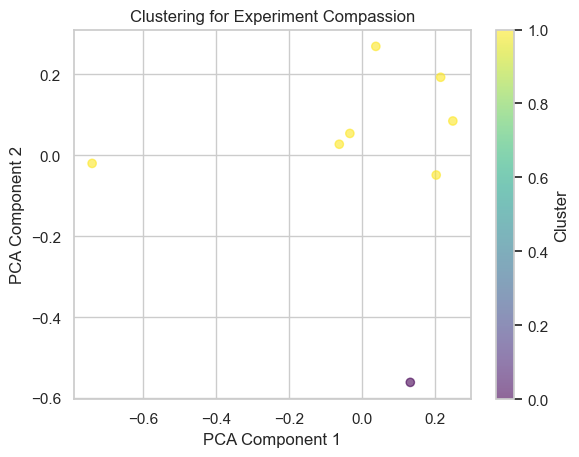

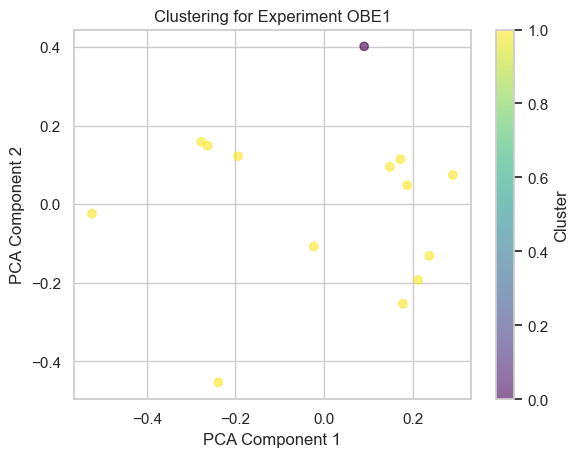

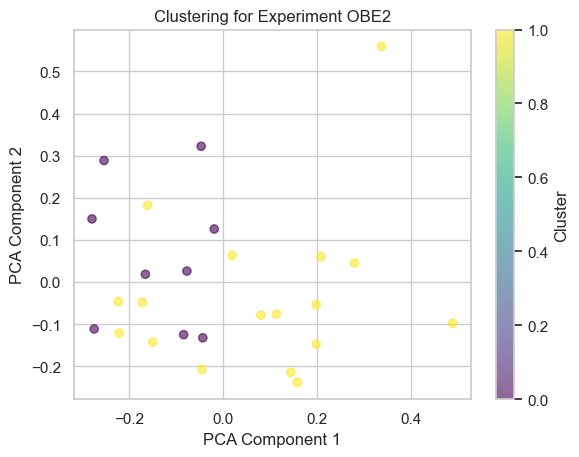

In [18]:
visualize_clusters(clustered_dfs_bert)

In [19]:
from sklearn.metrics import silhouette_score, davies_bouldin_score

def calculate_cluster_metrics(X, labels):
    silhouette = silhouette_score(X, labels)
    davies_bouldin = davies_bouldin_score(X, labels)
    return silhouette, davies_bouldin

def get_top_terms_tfidf(df, n_clusters=2, top_n=10):
    vectorizer = TfidfVectorizer(max_features=1000)
    X_tfidf = vectorizer.fit_transform(df['preprocessed_content'])
    terms = vectorizer.get_feature_names_out()
    cluster_terms = {}

    # Run clustering to get cluster labels
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    df['cluster'] = kmeans.fit_predict(X_tfidf)

    # Extract top terms for each cluster
    for cluster in range(n_clusters):
        indices = df[df['cluster'] == cluster].index
        cluster_tfidf = X_tfidf[indices].mean(axis=0).A1
        top_terms = terms[cluster_tfidf.argsort()[-top_n:]].tolist()
        cluster_terms[cluster] = top_terms
    
    return cluster_terms

from sklearn.metrics import adjusted_rand_score

def calculate_ari(labels_1, labels_2):
    return adjusted_rand_score(labels_1, labels_2)

In [20]:
# Calculate cluster quality metrics for TF-IDF
for i, (experiment_df, X_tfidf) in enumerate(zip(clustered_dfs_tfidf, tfidf_matrices)):
    silhouette, davies_bouldin = calculate_cluster_metrics(X_tfidf, experiment_df[0]['cluster'])
    experiment_name = experiment_df[0]["Experiment"].unique()[0]
    print(f"TF-IDF Clustering for Experiment {experiment_name} - Silhouette: {silhouette}, Davies-Bouldin: {davies_bouldin}")

# Get top terms for each TF-IDF cluster
top_terms = get_top_terms_tfidf(grouped_df, n_clusters=2, top_n=10)
print("Top terms for each TF-IDF cluster:", top_terms)


TF-IDF Clustering for Experiment Compassion - Silhouette: 0.0015732849063879676, Davies-Bouldin: 2.260212574221618
TF-IDF Clustering for Experiment OBE1 - Silhouette: 0.02899624291164298, Davies-Bouldin: 0.8704214492434089
TF-IDF Clustering for Experiment OBE2 - Silhouette: 0.019708167824322793, Davies-Bouldin: 3.5707679953735845
Top terms for each TF-IDF cluster: {0: ['one', 'see', 'feel', 'know', 'think', 'really', 'body', 'felt', 'yeah', 'like'], 1: ['feel', 'body', 'dont', 'see', 'know', 'think', 'time', 'like', 'yes', 'yeah']}


In [21]:
for i, (experiment_df, X_embeddings) in enumerate(zip(clustered_dfs_bert, bert_matrices)):
    silhouette, davies_bouldin = calculate_cluster_metrics(X_embeddings, experiment_df[0]['cluster'])
    experiment_name = experiment_df[0]["Experiment"].unique()[0]
    print(f"BERT Clustering for Experiment {experiment_name} - Silhouette: {silhouette}, Davies-Bouldin: {davies_bouldin}")

BERT Clustering for Experiment Compassion - Silhouette: 0.06600475311279297, Davies-Bouldin: 0.7527253869875876
BERT Clustering for Experiment OBE1 - Silhouette: 0.003353537991642952, Davies-Bouldin: 0.9083037268769777
BERT Clustering for Experiment OBE2 - Silhouette: 0.01948496326804161, Davies-Bouldin: 3.3498074563971674


In [22]:
# Calculate Adjusted Rand Index between TF-IDF and BERT clusters
tfidf_labels = [experiment_df[0]['cluster'].values for experiment_df in clustered_dfs_tfidf]
bert_labels = [experiment_df[0]['cluster'].values for experiment_df in clustered_dfs_bert]

for i, (tfidf, bert) in enumerate(zip(tfidf_labels, bert_labels)):
    ari = calculate_ari(tfidf, bert)
    print(f"Adjusted Rand Index for Experiment {i+1} between TF-IDF and BERT clusters: {ari:.2f}")

Adjusted Rand Index for Experiment 1 between TF-IDF and BERT clusters: 0.17
Adjusted Rand Index for Experiment 2 between TF-IDF and BERT clusters: 1.00
Adjusted Rand Index for Experiment 3 between TF-IDF and BERT clusters: -0.03


In [23]:
# Get representative sentences for BERT clusters
for i, (experiment_df, X_embeddings) in enumerate(zip(clustered_dfs_bert, bert_matrices)):
    experiment_name = experiment_df[0]["Experiment"].unique()[0]
    bert_representatives = get_representative_sentences(experiment_df[0], X_embeddings, n_clusters=2, top_n=5)
    print(f"Representative sentences for BERT clusters in {experiment_name}:")
    for cluster, sentences in bert_representatives.items():
        print(f"Cluster {cluster}:")
        for sentence in sentences:
            print(f"- {sentence}")

NameError: name 'get_representative_sentences' is not defined

In [ ]:
from umap import UMAP
import matplotlib.pyplot as plt

def visualize_clusters_umap(embeddings, labels):
    umap = UMAP(n_components=2, random_state=42)
    reduced_embeddings = umap.fit_transform(embeddings)
    plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], c=labels, cmap='viridis', alpha=0.6)
    plt.colorbar(label='Cluster')
    plt.title("BERT Embedding Clusters with UMAP")
    plt.xlabel("UMAP Dimension 1")
    plt.ylabel("UMAP Dimension 2")
    plt.show()

# Example usage after BERT clustering
kmeans_bert = KMeans(n_clusters=2, random_state=42).fit(bert_matrices[0])
visualize_clusters_umap(bert_matrices[0], kmeans_bert.labels_)


ImportError: cannot import name 'UMAP' from 'umap' (c:\Users\david\anaconda3\envs\basic\lib\site-packages\umap\__init__.py)

### Cluster 2.0

In [ ]:
# Preprocess text with the updated function
df_participant['preprocessed_content'] = df_participant['Content'].apply(preprocess_text)

# Group data by Experiment and Participant
grouped_df = df_participant.groupby(['Experiment', 'Id'])['preprocessed_content'].apply(' '.join).reset_index()

# Load the BERT model once
model = SentenceTransformer('all-MiniLM-L6-v2')

C:\Users\david\AppData\Local\Temp\ipykernel_22128\908853607.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_participant['preprocessed_content'] = df_participant['Content'].apply(preprocess_text)


In [ ]:
# Determine optimal number of clusters for TF-IDF
X_tfidf = TfidfVectorizer(max_features=1000, ngram_range=(1, 3)).fit_transform(grouped_df['preprocessed_content']).toarray()
find_optimal_clusters(X_tfidf, max_k=10)

In [ ]:
# Based on the plots, set optimal_k
optimal_k = 3

# Perform TF-IDF clustering
clustered_dfs_tfidf, tfidf_matrices = cluster_tfidf_kmeans(grouped_df, n_clusters=optimal_k)

# Visualize clusters with PCA
visualize_clusters(clustered_dfs_tfidf)

# Create word clouds for TF-IDF clusters
for experiment_df, _ in clustered_dfs_tfidf:
    create_wordclouds(experiment_df)

In [ ]:
# Repeat for BERT embeddings
X_embeddings = model.encode(grouped_df['preprocessed_content'].tolist())
find_optimal_clusters(X_embeddings, max_k=10)

In [ ]:
# Based on the plots, set optimal_k
optimal_k_bert = 3

clustered_dfs_bert, bert_matrices = cluster_bert_kmeans(grouped_df, model, n_clusters=optimal_k_bert)

# Visualize BERT clusters with t-SNE
visualize_clusters_tsne(clustered_dfs_bert, bert_matrices)

# Create word clouds for BERT clusters
for experiment_df, _ in clustered_dfs_bert:
    create_wordclouds(experiment_df)